# Audio signal preprocessing for machine learning classification models
author: Konrad Maciejczyk <br>
Wrocław University of Science and Technology, Trusted AI, 2023

In [1]:
import os
import csv
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import random
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, clone

from sklearn import neighbors, naive_bayes, svm

from scipy.stats import ttest_rel

## 1. Features engineering

In [2]:
def fft(samples):
    n = len(samples)
    if n <= 1:
        return samples

    even = fft(samples[0::2])
    odd = fft(samples[1::2])

    temp = np.zeros(n).astype(np.complex64)

    for u in range(n // 2):
        temp[u] = even[u] + np.exp(-2j * np.pi * u / n) * odd[u]
        temp[u + n // 2] = even[u] - np.exp(-2j * np.pi * u / n) * odd[u]

    return temp

In [3]:
def get_probes(dataset_name, classes, probes_per_class, shuffle):
    """Selecting probes from dataset."""    
    probes = []
    for class_name in classes:
        files = list(filter(lambda x: x.endswith('.wav'), os.listdir(dataset_name + '/' + class_name + '/')))

        if shuffle:
            random.shuffle(files)

        for f in files[:probes_per_class]:
            probes.append(f)
    
    random.shuffle(probes)
    return probes

def extract_features(dataset_name, probes, sample_section_start, sample_section_length, feature_amount):
    """Extracting features by calculating FFT and calculating integral of each interval"""    
    rows = []
    for probe in probes:
        row = []
        row.append(probe)
        aux = dataset_name + '/' + probe.split('.')[0] + '/' + probe
        try:
            samples, sampling_rate = librosa.load(aux, sr = None, mono = True, offset = 0.0, duration = None) #opening file 
        except:
            print("Could not load audio file: {}".format(probe.split('.')[0] + '/' + probe))
            
        
        

            samples = samples[sample_section_start * sampling_rate: sample_section_start*sampling_rate + sample_section_length * sampling_rate] #picking interval

            
            
        n = len(samples)
        try:
            harmonics = np.fft.fft(samples)
        except:
            print(f"n = {len(samples)}, a: {sample_section_start * sampling_rate}, b: {sample_section_start*sampling_rate + sample_section_length * sampling_rate}")
        
        #harmonics = fft(samples) #calculating fft
        harmonics = 2.0/n * np.abs(harmonics[:n//2]) #reducing complex domain into real domain
        aux = len(harmonics) // feature_amount
        for interval in range(0, feature_amount):
            a = interval * aux
            b = a + aux
            feature_value = np.trapz(harmonics[a: b]) #calculating integral for every interval
            row.append(feature_value)
        row.append(probe.split('.')[0])
        rows.append(row)
    return rows

def createDataset(csv_name, dataset_name, classes=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], probes_per_class=100, shuffle=True, samples_section_start = 9, samples_section_length = 3, feature_amount = 60, repeats = 1):
    """
    Parameters:
        csv_name = output csv file for extracted features
        dataset_name (string) dataset containing .wav files
        classes = (list) describe which classes should be included in probes picking
        probes_per_class = (int) number of probes for each class
        shuffle = (bool) permutate dataset randomly before picking up probes
        sample_section_start = (int) timestamp as seconds (1-17) corresponding to beginning of interval for each probe
        sample_section_length = (int) length as seconds corresponding to length of each interval
    """
    probes = get_probes(dataset_name, classes, probes_per_class, shuffle) #picking up probes
    rows = [['filename']]
    for feat_num in range(feature_amount):
        rows[0].append(f'feat_{feat_num +1}')
    rows[0].append('label')
    
    for repeat in range(repeats):
        results = extract_features(dataset_name, probes, samples_section_start + (samples_section_length * repeat), samples_section_length, feature_amount)
        for result in results:
            rows.append(result)
       
        

    #saving to csv file
    f = open(csv_name, 'w', newline="")   
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)
    f.close()

In [4]:
csv_file_name = 'extracted_features_3sec.csv'

In [5]:
createDataset(f'./{csv_file_name}', './genres_original', probes_per_class = 100, feature_amount = 50, samples_section_start = 1, samples_section_length = 3, repeats = 10)

/tmp/ipykernel_17454/2565783658.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sampling_rate = librosa.load(aux, sr = None, mono = True, offset = 0.0, duration = None) #opening file
/home/konrad/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav
Could not load audio file: jazz/jazz.00054.wav


## 2. CSV file overview

In [6]:
def loadData(path):
    datapd = pd.read_csv(path)
    genres = datapd['label'].unique()
    datapd['label'] = pd.factorize(datapd['label'])[0]
    return datapd, genres

In [7]:
datapd, genres = loadData(f"./{csv_file_name}") # dataset created by my method
#datapd, genres = loadData("./gtzan_extracted_features.csv")
#datapd, genres = loadData("./features_3_sec.csv")
#datapd, star_types = loadData("./features_30_sec.csv")
datapd.shape

(10000, 52)

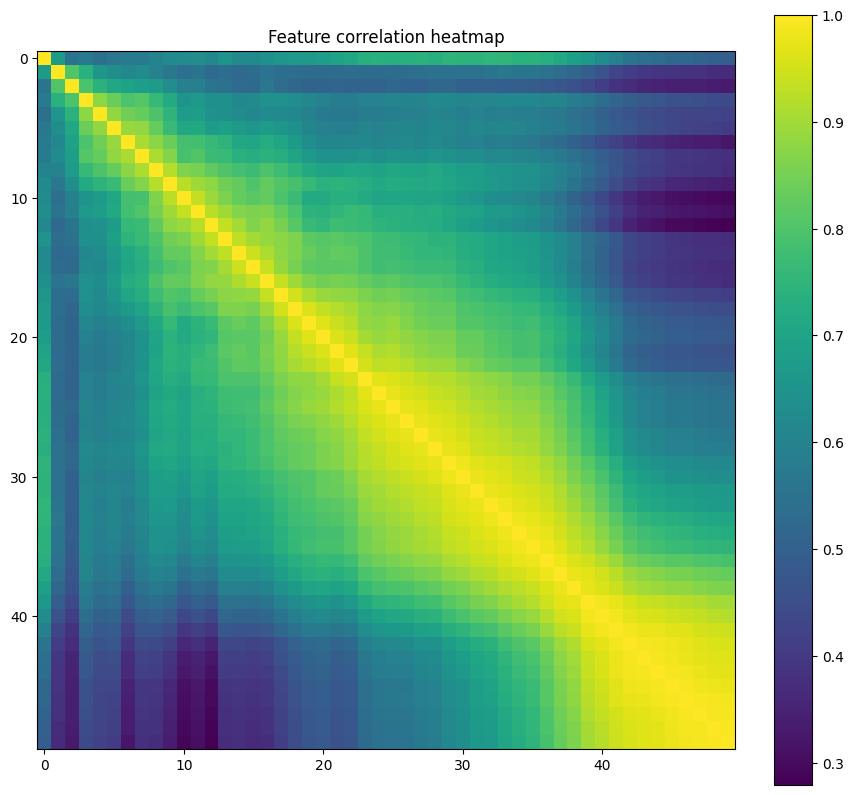

In [8]:
pear_corr=datapd.drop(['filename', 'label'], axis=1).corr(method='pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(pear_corr, interpolation='nearest')
plt.title("Feature correlation heatmap")
fig.colorbar(im, orientation='vertical', fraction = 0.05)

## 3. Loading and visualizing audio files

In [20]:
track_num = '00054'
# file_path = f'genres_original/blues/blues.{track_num}.wav'
# file_path = f'genres_original/classical/classical.{track_num}.wav'
# file_path = f'genres_original/country/country.{track_num}.wav'
# file_path = f'genres_original/disco/disco.{track_num}.wav'
# file_path = f'genres_original/hiphop/hiphop.{track_num}.wav'
file_path = f'genres_original/metal/metal.{track_num}.wav'
# file_path = f'genres_original/pop/pop.{track_num}.wav'
# file_path = f'genres_original/reggae/reggae.{track_num}.wav'
# file_path = f'genres_original/jazz/jazz.{track_num}.wav'
# file_path = f'genres_original/rock/rock.{track_num}.wav'
(samples, sampling_rate) = librosa.load(file_path, sr = None, mono = True, offset = 0.0, duration = None)

duration = len(samples) / sampling_rate
print('Duration of single sound file: {:.1f} seconds.'.format(duration))

Duration of single sound file: 30.0 seconds.


In [21]:
Audio(file_path)

### Picking time interval 

In [22]:
var = random.randint(0, 26)
begin = 22050 * var
interval_length = 3
samples = samples[begin: begin + interval_length * sampling_rate]

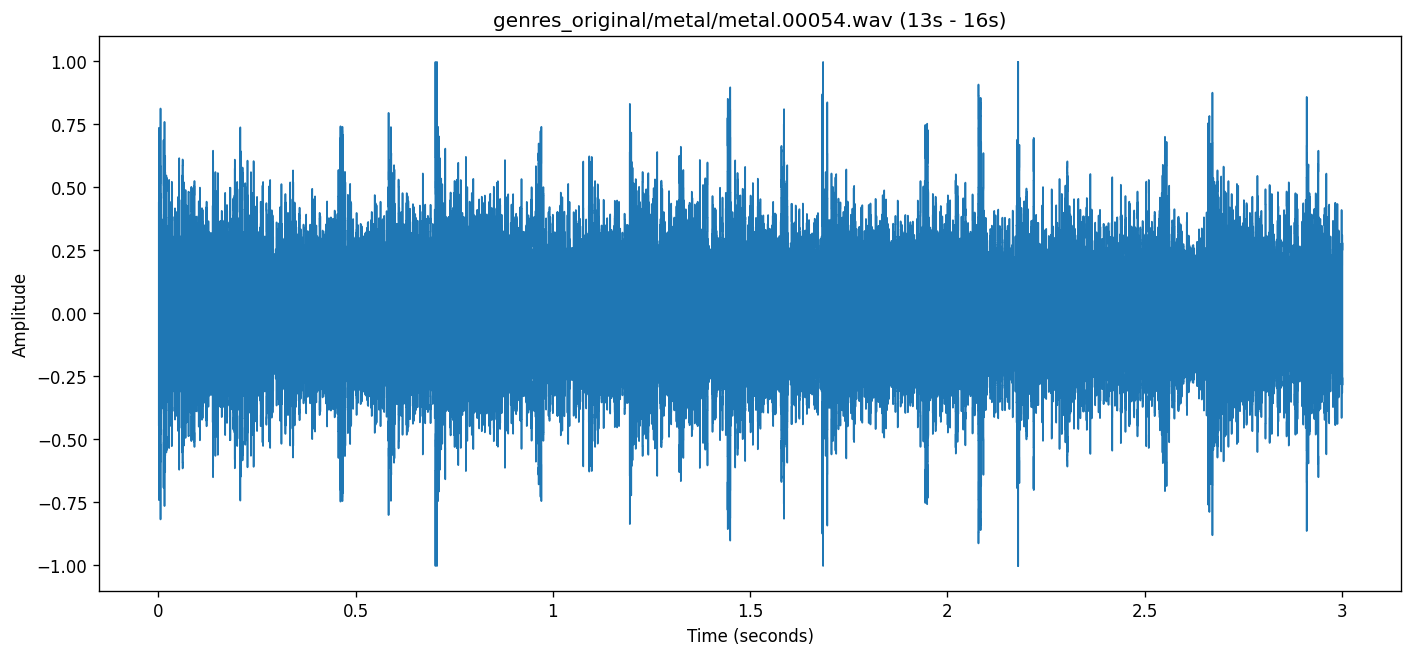

In [23]:
plt.figure(figsize = (14, 6), dpi = 120)
librosa.display.waveshow(y = samples, sr = sampling_rate)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(file_path + f' ({var}s - {var + interval_length}s)')
plt.show()

### Applying FFT for given track fragment

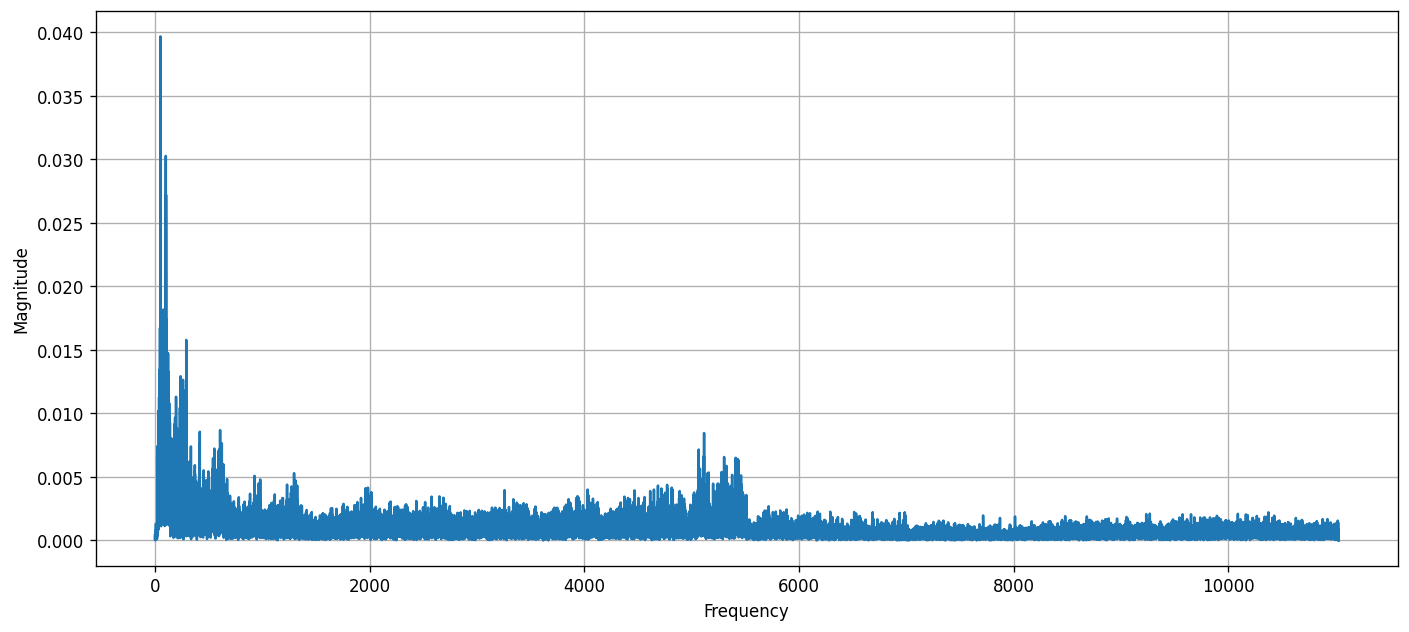

In [24]:
T = 1/sampling_rate
n = len(samples)
y = fft(samples)
x = np.linspace(0.0, 1.0/(2.0*T), n//2)
plt.figure(figsize = (14, 6), dpi = 120)
plt.plot(x, 2.0/n * np.abs(y[:n//2]))
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

## 4. Spliting and scaling data

In [9]:
def normalize_data(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    return x_train, x_test

In [26]:
def dataSplit(data, random_state = 42, test_size=.2, verbose=False):
    X = data.drop(['filename', 'label'], axis = 1).to_numpy()
    y = data['label'].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=.2)

    if verbose:
        print("x_train={}, x_test={}, y_train={}, y_test={}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

    return x_train, x_test, y_train, y_test

In [27]:
x_train, x_test, y_train, y_test = dataSplit(datapd)
x_train, x_test = normalize_data(x_train, x_test)

## 4. Building models

### > Using KNN algorithm

In [28]:
class KNN:
    """A k-nearest neighbors classifier. Similar class to KNeighborsClassifier from module sklearn.neighbors.
    Methods:
        fit(np.array(X_train), np.array(y_train)) - model training method
        predict(np.array(X_test)) - method returning a numpy array of predicted class labels for input test data.
        score(np.array(X_test, y_test)) - method checking accuracy of the model by. Returns float number.
    """
    def __init__(self, k = 1):
        if k < 1 or type(k) is not int:
            raise ValueError("Number of nearest neighbors mu be positive integer.")

        self.k = k #k_neighbors
        self.x_train = None #storing data
        self.y_train = None #storing target

    def fit(self, A, B):
        if A.shape[0] != B.shape[0]:
            print(A.shape[0], B.shape[0])
            raise ValueError("Training and testing sets are not same size")

        self.x_train = A #fiting data
        self.y_train = B

    def predict(self, A):
        if type(A) is not np.ndarray:
            raise ValueError("Both sets must numpy.ndarray type.")

        result = np.array([]).astype('int16')
        i = 0
        n = A.shape[0]
        while i < n:
            distance = self._distance(A[i])
            distance = self.y_train[np.argsort(distance)[:self.k]]
            distance = np.bincount(distance)
            distance = np.argmax(distance)

            result = np.append(result, distance)
            i += 1
        
        return result

    def score(self, X, Y):
        if X.shape[0] != Y.shape[0]:

            raise ValueError("Training and are not same size")
        
        result = self.predict(X)
        return np.mean(result == Y)

    def _distance(self, A):
        """Auxillary method for computing distances between one of the testing vector and other training vectors"""
        return np.sqrt(np.sum(np.power(A - self.x_train, 2), axis = 1))

In [29]:
def runKNN(x_train, x_test, y_train, y_test, neighbors = 3):
    my_knn_clf = KNN(k=neighbors)
    my_knn_clf.fit(x_train, y_train)
    print("Testing set score accuracy: {:.2f}% for KNN({})".format(my_knn_clf.score(x_test, y_test)*100, neighbors))

In [30]:
#my knn
runKNN(x_train, x_test, y_train, y_test)

Testing set score accuracy: 64.00% for KNN(3)


In [31]:
#sklearn KNN
sklearn_knn = neighbors.KNeighborsClassifier(n_neighbors=3)
sklearn_knn.fit(x_train, y_train)
sklearn_knn.score(x_test, y_test)

0.64

### > using Nearest-Centroid algorithm

In [32]:
class NearestCentroid(object):
    """A nearest centroid classifier. Similar class to NearestCentroid from module sklearn.neighbors.
    Methods:
        fit(np.array(X_train), np.array(y_train)) - model training method
        predict(np.array(X_test)) - method returning a numpy array of predicted class labels for input test data.
        score(np.array(X_test, y_test)) - method checking accuracy of the model by. Returns float number.
    """
    def __int__(self):
        self.repr = None
        
    def _find_means(self, x_train, y_train):
        """Auxillary method used for computing feature classes means."""
        return np.array([np.mean(x_train[y_train == i], axis = 0) for i in np.unique(y_train)])

    def _find_distance(self, x):
        """Auxillary method for computing distances between one of the testing vector and classes feature means."""
        return np.sqrt(np.sum(np.power(self.repr - x, 2), axis = 1))

    def fit(self, x_train, y_train):
        if x_train.shape[0] != y_train.shape[0]:
            print(x_train.shape[0], y_train.shape[0])
            raise ValueError("Training and testing sets are not same size")
            
        self.repr = self._find_means(x_train, y_train)

    
    def predict(self, A):
        if type(A) is not np.ndarray:
            raise ValueError("Both sets must numpy.ndarray type.")
        
        result = np.array([]).astype('int8')
        i = 0
        n = A.shape[0]
        while i < n:
            result = np.append(result , np.argmin(self._find_distance(A[i])))
            i += 1
        return result

    def score(self, A, B):
        results = self.predict(A)
        return np.mean(results == B)

In [33]:
def runNearestCentroid(x_train, x_test, y_train, y_test):
    my_min_centroid_clf = NearestCentroid()
    my_min_centroid_clf.fit(x_train, y_train)
    print("Testing set score accuracy: {:.2f}% for NearestCentroid".format(my_min_centroid_clf.score(x_test, y_test)*100))

In [34]:
#my nearest centroid
runNearestCentroid(x_train, x_test, y_train, y_test)

Testing set score accuracy: 34.00% for NearestCentroid


In [35]:
#sklearn Nearest-Centroid
sklearn_nc = neighbors.NearestCentroid()
sklearn_nc.fit(x_train, y_train)
y_pred = sklearn_nc.predict(x_test)
np.mean(y_pred == y_test) * 100

34.0

### > using SVM

In [101]:
#sklearn SVM
sklearn_svm = svm.SVC()
sklearn_svm.fit(x_train, y_train)
y_pred = sklearn_svm.predict(x_test)
np.mean(y_pred == y_test) * 100

48.0

## 5. Experimental loop and statistical tests

In [12]:
rskf = RepeatedStratifiedKFold(n_repeats= 5, n_splits = 2)

features_3_sec_dataset = pd.read_csv('extracted_features_3sec.csv')
features_5_sec_dataset = pd.read_csv('extracted_features_5sec.csv')
features_10_sec_dataset = pd.read_csv('extracted_features_10sec.csv')
features_15_sec_dataset = pd.read_csv('extracted_features_15sec.csv')
features_30_sec_dataset = pd.read_csv('extracted_features_30sec.csv')

DATASETS = [features_30_sec_dataset, features_15_sec_dataset, features_10_sec_dataset, features_5_sec_dataset, features_3_sec_dataset]
CLASSIFIERS = [neighbors.KNeighborsClassifier(), neighbors.NearestCentroid(), naive_bayes.GaussianNB(), svm.SVC()]

scores = np.zeros(shape = (len(DATASETS), len(CLASSIFIERS), rskf.get_n_splits()))

In [13]:
for dataset_idx, dataset in enumerate(DATASETS):
    X = dataset.drop(['label', 'filename'], axis = 1).to_numpy()
    dataset['label'] = pd.factorize(dataset['label'])[0]
    y = dataset['label'].to_numpy()
    for classifier_idx, clf_prot in enumerate(CLASSIFIERS):
        for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
            X[train], X[test] = normalize_data(X[train], X[test])
            clf = clone(clf_prot)
            clf.fit(X[train], y[train])
            score = clf.score(X[test], y[test])
            scores[dataset_idx, classifier_idx, fold_idx] = score

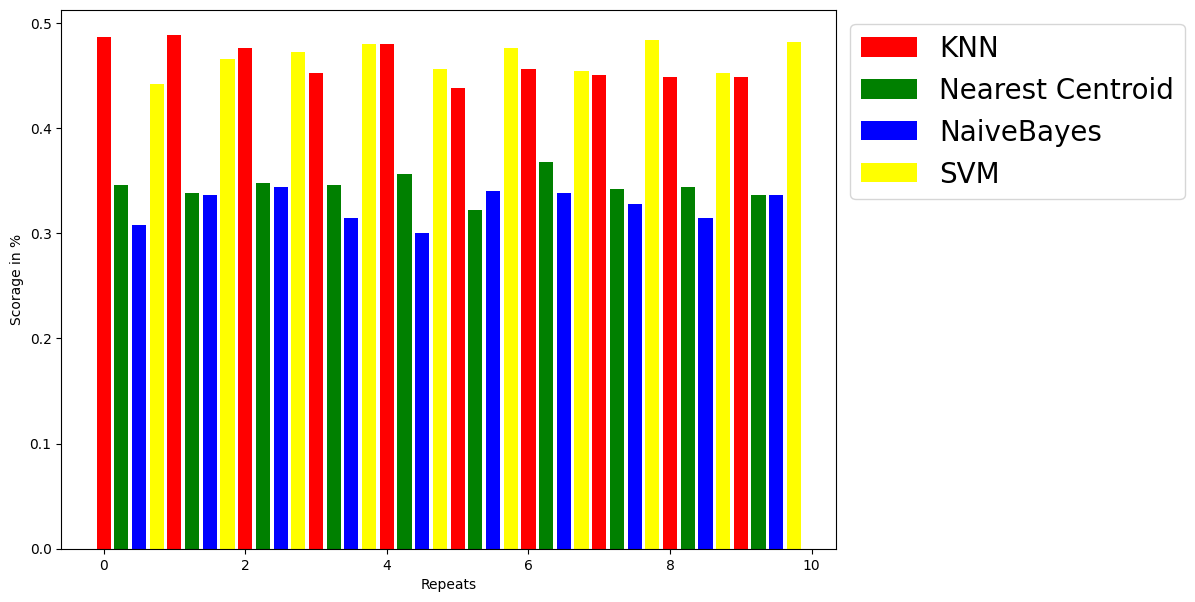

In [22]:
colors = ['red', 'green', 'blue', 'yellow']
x = ['KNN', "Nearest Centroid", "NaiveBayes", "SVM"]
y = []

for idx, classifier in enumerate(x):
    y.append(scores[0, idx, :])

xpos = np.arange(len(y[0]))
barwidth = 0.2
plt.figure(figsize = (10, 7))
for idx, classifier in enumerate(x):
    plt.bar(xpos + (0.25 * idx), y[idx], color=colors[idx], width = barwidth, label=classifier)


plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize="20")
#plt.title("extracted_features_30sec.csv - classifiers predicition accuracy")
plt.xlabel("Repeats")
plt.ylabel("Scorage in %")
plt.show()

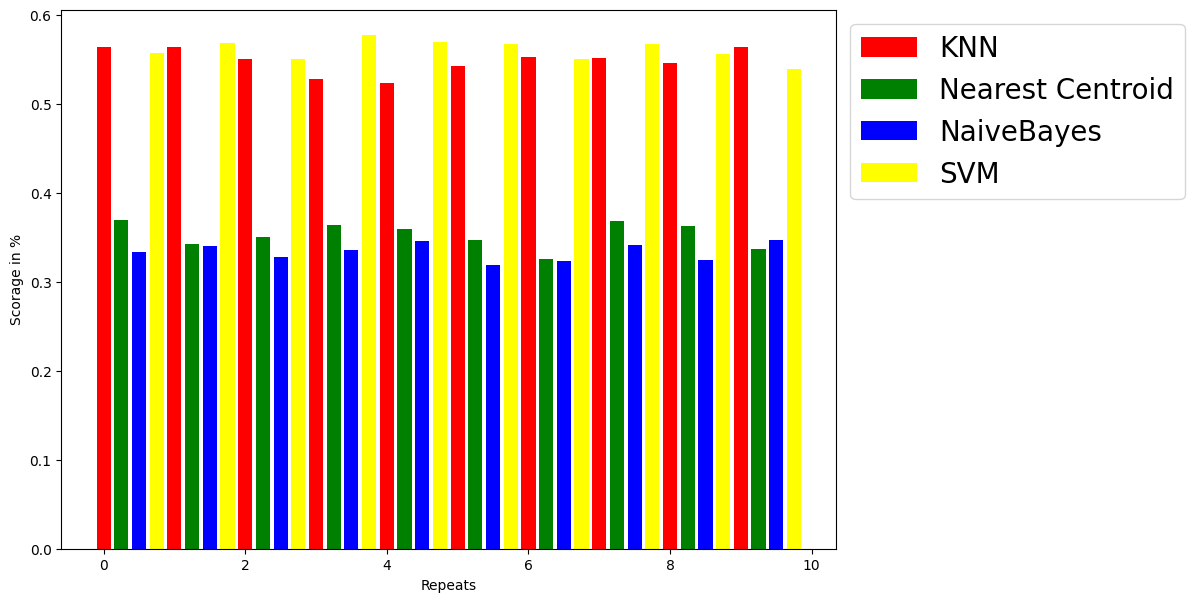

In [23]:
y = []

for idx, classifier in enumerate(x):
    y.append(scores[1, idx, :])

xpos = np.arange(len(y[0]))
barwidth = 0.2
plt.figure(figsize = (10, 7))
for idx, classifier in enumerate(x):
    plt.bar(xpos + (0.25 * idx), y[idx], color=colors[idx], width = barwidth, label=classifier)


plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize="20")
#plt.title("extracted_features_15sec.csv - classifiers predicition accuracy")
plt.xlabel("Repeats")
plt.ylabel("Scorage in %")
plt.show()

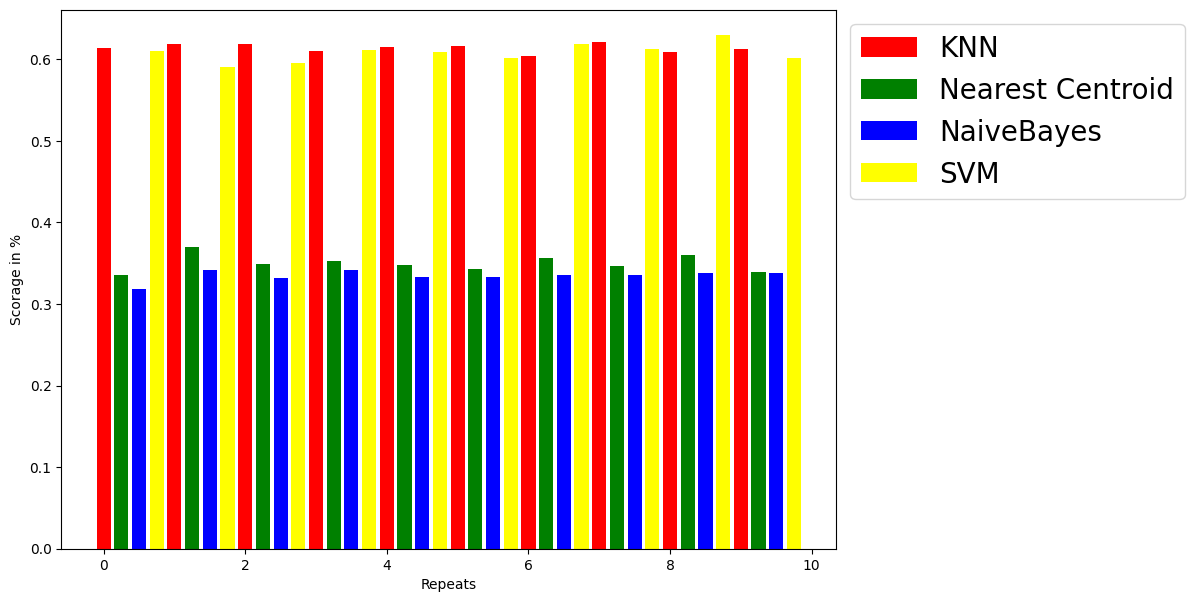

In [24]:
y = []

for idx, classifier in enumerate(x):
    y.append(scores[2, idx, :])

xpos = np.arange(len(y[0]))
barwidth = 0.2
plt.figure(figsize = (10, 7))
for idx, classifier in enumerate(x):
    plt.bar(xpos + (0.25 * idx), y[idx], color=colors[idx], width = barwidth, label=classifier)


plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize="20")
#plt.title("extracted_features_10sec.csv - classifiers predicition accuracy")
plt.xlabel("Repeats")
plt.ylabel("Scorage in %")
plt.show()

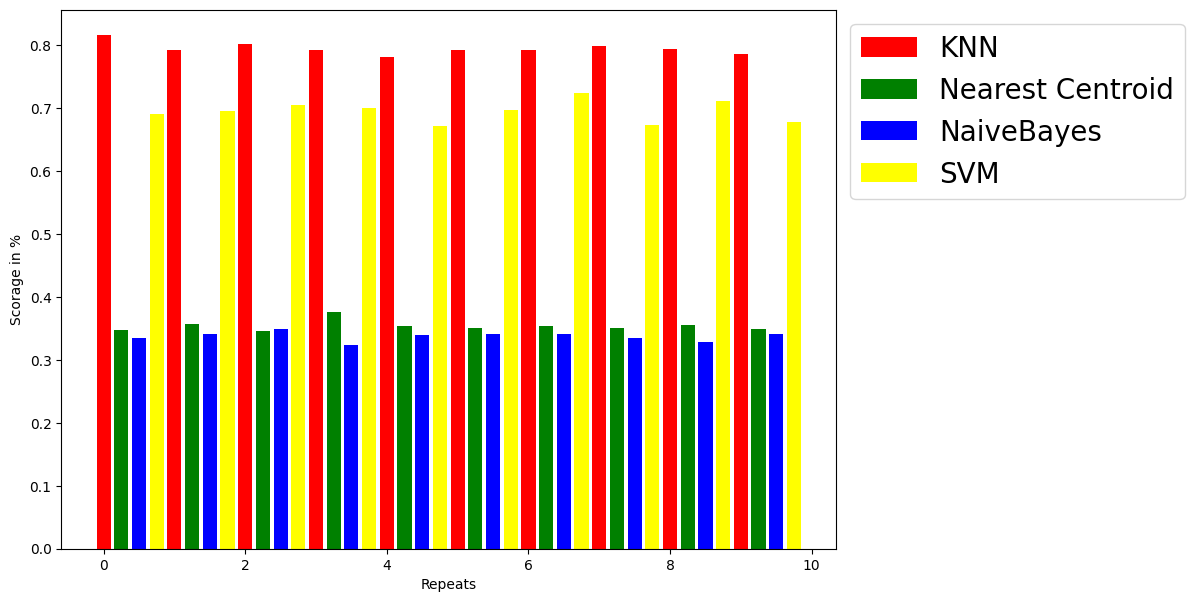

In [25]:
y = []

for idx, classifier in enumerate(x):
    y.append(scores[3, idx, :])

xpos = np.arange(len(y[0]))
barwidth = 0.2
plt.figure(figsize = (10, 7))
for idx, classifier in enumerate(x):
    plt.bar(xpos + (0.25 * idx), y[idx], color=colors[idx], width = barwidth, label=classifier)


plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize="20")
#plt.title("extracted_features_5sec.csv - classifiers predicition accuracy")
plt.xlabel("Repeats")
plt.ylabel("Scorage in %")
plt.show()

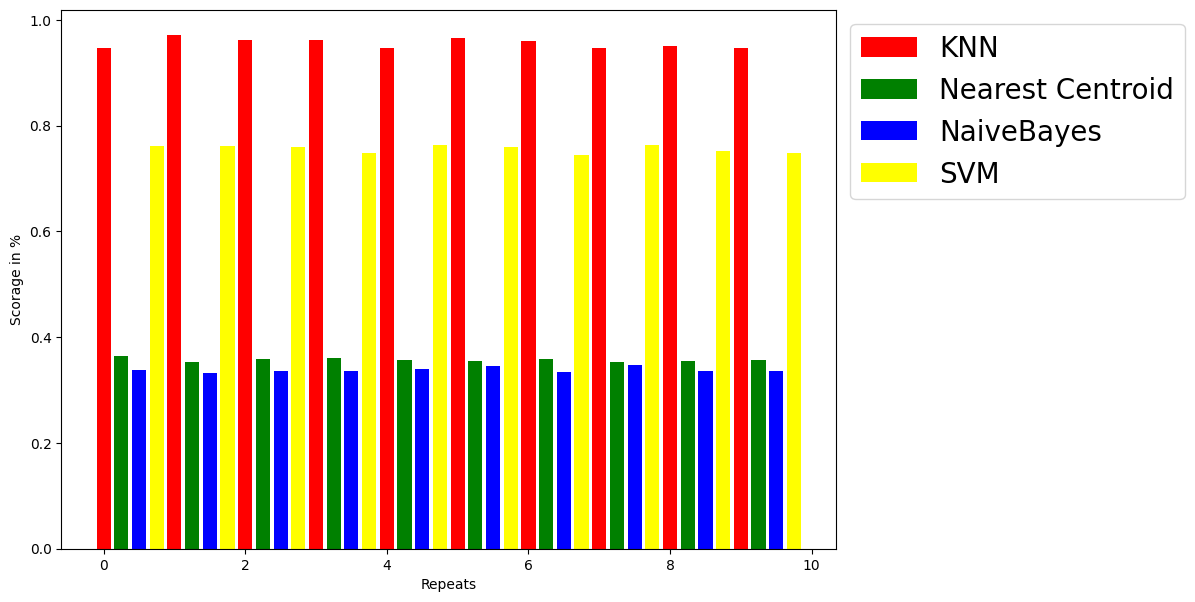

In [26]:
y = []

for idx, classifier in enumerate(x):
    y.append(scores[4, idx, :])

xpos = np.arange(len(y[0]))
barwidth = 0.2
plt.figure(figsize = (10, 7))
for idx, classifier in enumerate(x):
    plt.bar(xpos + (0.25 * idx), y[idx], color=colors[idx], width = barwidth, label=classifier)


plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize="20")
#plt.title("extracted_features_3sec.csv - classifiers predicition accuracy")
plt.xlabel("Repeats")
plt.ylabel("Scorage in %")
plt.show()

In [64]:
result = ttest_rel(scores[3, 3, :], scores[4, 3, :])
print("{:.10f}".format(result.pvalue))

0.0000076189
